In [13]:
!pip install labml
!pip install labml_nn

In [9]:

import math


import torch
from labml import tracker
from torch import nn

from labml_nn.optimizers import GenericAdaptiveOptimizer, WeightDecay

In [44]:

import math
import torch

from torch import nn
from labml_nn.optimizers import GenericAdaptiveOptimizer, WeightDecay

'''
Adam class implementation
|--> init
|--> init_state
|--> getmv
|--> getlr
|--> adapUpdate
|--> stepParam
'''

class Adam(GenericAdaptiveOptimizer):
  def __init__(self, params,
               lr : float = 1e-3,
               betas = (0.9, 0.999),
               eps : float = 1e-16,
               weightDecay = WeightDecay(),
               optimizedUpdate: bool = True,
               defaults = None
               ) -> None:

    defaults = {} if defaults is None else defaults
    defaults.update(weightDecay.defaults())
    super().__init__(params, defaults, lr, betas, eps)

    self.weightDecay = weightDecay
    self.optimizedUpdate = optimizedUpdate

  def init_state(self, state, group, param: nn.Parameter) -> None:
    state['step'] = 0
    state['expAvg'] = torch.zeros_like(param, memory_format=torch.preserve_format)
    state['expAvgSq'] = torch.zeros_like(param, memory_format=torch.preserve_format)

  def get_mv(self, state, group, grad: torch.Tensor):
    beta1, beta2 = group['betas']

    m,v = state['expAvg'], state['expAvgSq']
    m.mul_(beta1).add_(grad, alpha=1 - beta1)
    v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

    return m,v

  def get_lr(self, state, group):
    return group["lr"]

  def adam_update(self, state, group, param : torch.nn.Parameter, m: torch.Tensor, v : torch.Tensor):
    beta1, beta2 = group['betas']

    biasCorrection1 = 1 - beta1 ** state['step']
    biasCorrection2 = 1 - beta2 ** state['step']

    lr = self.get_lr(state, group)

    if self.optimizedUpdate:
      denominator = v.sqrt().add_(group['eps'])
      stepSize = lr * math.sqrt(biasCorrection2) / biasCorrection1

      param.data.addcdiv_(m, denominator, value = -stepSize)

    else:
      denominator = (v.sqrt() / math.sqrt(biasCorrection2)).add_(group['eps'])
      stepSize = lr / biasCorrection1
      param.data.addcdiv_(m, denominator, value = -stepSize)

  def step_param(self, state, group, grad : torch.Tensor, param : torch.nn.Parameter):
    grad = self.weightDecay(param, grad, group)
    m, v = self.get_mv(state, group, grad)
    state['step'] += 1
    self.adam_update(state, group, param, m, v)


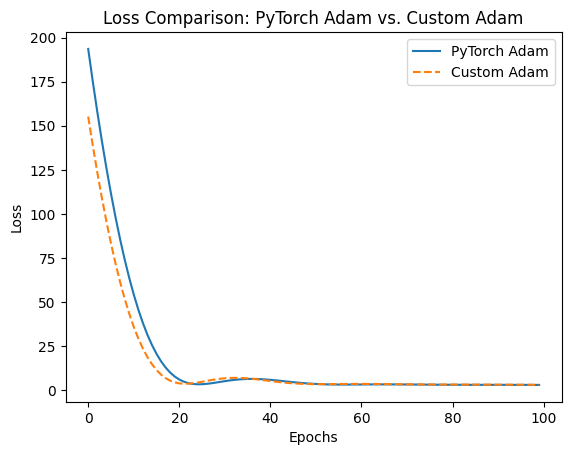

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Import your custom Adam optimizer

# Generate dummy dataset (simple regression task)
torch.manual_seed(42)
X = torch.rand(100, 1) * 10  # Inputs from 0 to 10
y = 2 * X + 3 + torch.randn(100, 1) * 2  # Linear relation y = 2x + 3 + noise

# Define a simple linear model
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

# Function to train the model
def train(model, optimizer, num_epochs=100):
    criterion = nn.MSELoss()
    losses = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        predictions = model(X)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses

# Train with PyTorch Adam
model1 = SimpleModel()
optimizer1 = optim.Adam(model1.parameters(), lr=0.1)
losses1 = train(model1, optimizer1)

# Train with Custom Adam
model2 = SimpleModel()
optimizer2 = Adam(model2.parameters(), lr=0.1)
losses2 = train(model2, optimizer2)

# Plot the loss curves
plt.plot(losses1, label="PyTorch Adam")
plt.plot(losses2, label="Custom Adam", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Comparison: PyTorch Adam vs. Custom Adam")
plt.show()
